In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import node2vec

import torch
import torch_geometric as tg

from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import adjusted_rand_score

## Read Data

### AIDS Data
https://networkrepository.com/AIDS.php

In [3]:
AIDS_EDGES = None
AIDS_LABELS = None

with open('data/AIDS/AIDS.edges.txt') as edges_file:
    AIDS_EDGES = np.loadtxt(edges_file, dtype=int, delimiter=',')

with open('data/AIDS/AIDS.node_labels.txt') as nodes_file:
    AIDS_LABELS = np.loadtxt(nodes_file, dtype=int, delimiter=',')
    AIDS_LABELS = AIDS_LABELS[:, 1]

### FB CMU Data
https://networkrepository.com/fb-CMU-Carnegie49.php

In [4]:
FB_CMU_EDGES = None
FB_CMU_LABELS = None

with open('data/fb-CMU-Carnegie49/fb-CMU-Carnegie49.edges.txt') as edges_file:
    FB_CMU_EDGES = np.loadtxt(edges_file, dtype=int, delimiter=' ')

with open('data/fb-CMU-Carnegie49/fb-CMU-Carnegie49.node_labels.txt') as nodes_file:
    FB_CMU_LABELS = np.loadtxt(nodes_file, dtype=int, delimiter=',')
    FB_CMU_LABELS = FB_CMU_LABELS[:, 1]

## Web Spam Detection Data
https://networkrepository.com/web-spam-detection.php

In [5]:
SPAM_EDGES = None
SPAM_LABELS = None

with open('data/web-spam-detection/web-spam-detection.edges.txt') as edges_file:
    SPAM_EDGES = np.loadtxt(edges_file, dtype=int, delimiter=',')

with open('data/web-spam-detection/web-spam-detection.node_labels.txt') as nodes_file:
    SPAM_LABELS = np.loadtxt(nodes_file, dtype=int, delimiter=',')
    SPAM_LABELS = SPAM_LABELS[:, 1]

## Data Preprocessing

In [6]:
# X = AIDS_EDGES
# Y = AIDS_LABELS

X = FB_CMU_EDGES
Y = FB_CMU_LABELS

# X = SPAM_EDGES
# Y = SPAM_LABELS

In [7]:
G = nx.DiGraph()
G.add_edges_from(X)

In [8]:
EPOCHS = 1000
LR = 0.01
NUM_NODES = np.max(X)
NUM_CLASSES_CLUSTERS = np.max(Y)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
data = tg.data.Data(
    x=torch.eye(NUM_NODES), 
    edge_index=torch.tensor(X-1, dtype=torch.long).t().contiguous(), 
    y=torch.nn.functional.one_hot(torch.tensor(Y-1, dtype=torch.long), NUM_CLASSES_CLUSTERS)).to(device)
    # y=torch.tensor(Y-1, dtype=torch.long)).to(device)

## Graph Convolutional Network

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = tg.nn.GCNConv(num_node_features, 512)
        self.conv2 = tg.nn.GCNConv(512, 256)
        # self.conv3 = tg.nn.GCNConv(512, 256)
        # self.conv4 = tg.nn.GCNConv(256, 128)
        self.fc1 = torch.nn.Linear(256, 128)
        # self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(128, num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        # x = self.conv3(x, edge_index)
        # x = torch.nn.functional.relu(x)
        # x = torch.nn.functional.dropout(x, training=self.training)
        # x = self.conv4(x, edge_index)
        # x = torch.nn.functional.relu(x)
        # x = torch.nn.functional.dropout(x, training=self.training)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        # x = self.fc2(x)
        # x = torch.nn.functional.relu(x)
        x = self.fc3(x)
        # x = torch.nn.functional.relu(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

In [11]:
model = GCN(num_node_features=NUM_NODES, num_classes=NUM_CLASSES_CLUSTERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()

In [12]:
loss_list = []
accuracy_list = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y.float())
    loss.backward()
    optimizer.step()

    # validate the model
    model.eval()
    _, pred = model(data).max(dim=1)
    _, true_labels = torch.max(data.y.float(), dim=1)
    correct = float(pred.eq(true_labels).sum().item())
    acc = correct / len(data.y)
    loss_list.append(loss.item())
    accuracy_list.append(acc)
    if (epoch+1) % 100 == 0:
        print(f'Epoch: {epoch+1:03d}\t Loss: {loss:.4f}\t Val Acc: {acc:.4f}')

Epoch: 100	 Loss: 0.1315	 Val Acc: 0.7540


In [13]:
# test the model
model.eval()
_, pred = model(data).max(dim=1)
_, true_labels = torch.max(data.y.float(), dim=1)
correct = float(pred.eq(true_labels).sum().item())
acc = correct / len(data.y)
print(f'Test Acc: {acc:.4f}')

Test Acc: 0.7540


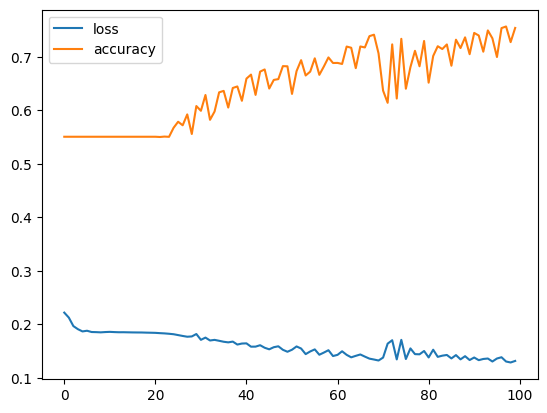

In [14]:
# plot loss and accuracy
plt.plot(loss_list)
plt.plot(accuracy_list)
plt.legend(['loss', 'accuracy'])
plt.show()

## Graph Encoder Embedding

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(Encoder, self).__init__()
        self.conv1 = tg.nn.GCNConv(num_features, 256)
        self.conv2 = tg.nn.GCNConv(256, 128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, num_classes)

    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.dropout(x, training=self.training)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.fc2(x)
        # x = torch.nn.functional.relu(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

In [ ]:
def decode(embeddings):
    adj_reconstructed = torch.sigmoid(torch.matmul(embeddings, embeddings.t()))
    return adj_reconstructed

In [ ]:
class GAE(torch.nn.Module):
    def __init__(self, encoder):
        super(GAE, self).__init__()
        self.encoder = encoder

    def forward(self, x, edge_index):
        embeddings = self.encoder(x, edge_index)
        return decode(embeddings)

In [ ]:
def loss_function(reconstructed_adj, edge_index):
    # Convert edge_index to adjacency matrix
    adj_original = torch.zeros(reconstructed_adj.shape)
    adj_original[edge_index[0], edge_index[1]] = 1
    
    # Binary cross-entropy loss
    return torch.nn.functional.binary_cross_entropy(reconstructed_adj, adj_original)

In [ ]:
# Initialize model and optimizer
encoder_model = Encoder(data.num_nodes, num_classes=NUM_CLASSES_CLUSTERS)
model = GAE(encoder_model)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    reconstructed_adj = model(data.x, data.edge_index)
    loss = loss_function(reconstructed_adj, data.edge_index)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

## Spectral Embedding

In [ ]:
adjacency_matrix = np.zeros((NUM_NODES, NUM_NODES))
adjacency_matrix[X[:, 0]-1, X[:, 1]-1] = 1
adjacency_matrix[X[:, 1]-1, X[:, 0]-1] = 1

In [ ]:
embedding = SpectralEmbedding(n_components=10)  # 2D embedding
spectral_embedding = embedding.fit_transform(adjacency_matrix)

lda_spectral = LinearDiscriminantAnalysis(n_components=2)
lda_spectral.fit(spectral_embedding, Y)
Y_PRED_LDA_SPECTRAL = lda_spectral.predict(spectral_embedding)

qda_spectral = QuadraticDiscriminantAnalysis()
qda_spectral.fit(spectral_embedding, Y)
Y_PRED_QDA_SPECTRAL = qda_spectral.predict(spectral_embedding)


kmeans_spectral = KMeans(n_clusters=NUM_CLASSES_CLUSTERS)
clusters = kmeans_spectral.fit_predict(spectral_embedding)

In [ ]:
print(f"Accuracy: {np.sum(Y == Y_PRED_QDA_SPECTRAL) / len(Y)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y-1, Y_PRED_QDA_SPECTRAL)}")

## Node2Vec

In [ ]:
node2vec_model = node2vec.Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

model = node2vec_model.fit(window=10, min_count=1, batch_words=4)

embeddings = model.wv

node_ids = list(G.nodes())  # List of nodes in the graph
embedding_matrix = np.array([model.wv[str(node_id)] for node_id in node_ids])

lda_node = LinearDiscriminantAnalysis(n_components=2)
lda_node.fit(embedding_matrix, Y)
Y_PRED_LDA_NODE = lda_node.predict(embedding_matrix)

qda = QuadraticDiscriminantAnalysis()
qda.fit(embedding_matrix, Y)
Y_PRED_QDA_NODE = qda.predict(embedding_matrix)

# kmeans = KMeans(n_clusters=NUM_CLASSES_CLUSTERS)
# clusters = kmeans.fit_predict(embedding_matrix)

In [ ]:
print(f"Accuracy: {np.sum(Y == Y_PRED_QDA_NODE) / len(Y)}")
print(f"Adjusted Rand Index: {adjusted_rand_score(Y-1, Y_PRED_QDA_NODE)}")